# Percobaan 1


Scaled Dot-Product Attention:
Output shape: (2, 4, 10)
Attention weights shape: (2, 4, 6)
Attention weights sum: [[1. 1. 1. 1.]
 [1. 1. 1. 1.]]

Additive Attention:
Output shape: (2, 4, 10)
Attention weights shape: (2, 4, 6)
Attention weights sum: [[1. 1. 1. 1.]
 [1. 1. 1. 1.]]


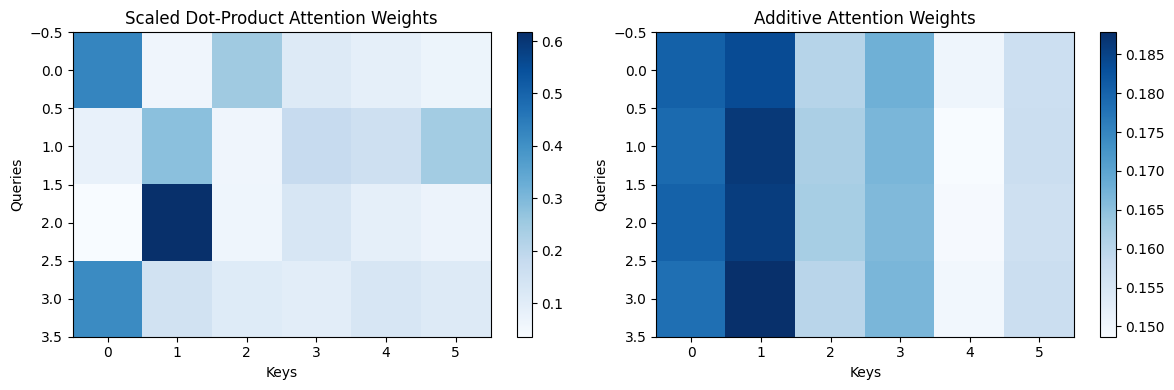

In [43]:
import numpy as np
import matplotlib.pyplot as plt

def softmax(x, axis=-1):
    """Compute softmax values"""
    exp_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return exp_x / np.sum(exp_x, axis=axis, keepdims=True)

def scaled_dot_product_attention(Q, K, V, mask=None):
    """
    Scaled Dot-Product Attention
    
    Args:
        Q: Queries (batch_size, n_queries, d_k)
        K: Keys (batch_size, n_keys, d_k)
        V: Values (batch_size, n_keys, d_v)
        mask: Optional mask (batch_size, n_queries, n_keys)
    Returns:
        output: Attention output
        attention_weights: Attention weights
    """
    d_k = Q.shape[-1]
    # Compute attention scores
    scores = np.matmul(Q, K.transpose(0, 2, 1)) / np.sqrt(d_k)
    # Apply mask if provided
    if mask is not None:
        scores = scores + (mask * -1e9)
    # Compute attention weights
    attention_weights = softmax(scores, axis=-1)
    # Compute output
    output = np.matmul(attention_weights, V)
    return output, attention_weights

def additive_attention(Q, K, V, W_q, W_k, w_v):
    """
    Additive Attention (Bahdanau)
    
    Args:
        Q: Queries (batch_size, n_queries, d_q)
        K: Keys (batch_size, n_keys, d_k)
        V: Values (batch_size, n_keys, d_v)
        W_q: Query projection (d_q, h)
        W_k: Key projection (d_k, h)
        w_v: Score projection (h,)
    Returns:
        output: Attention output
        attention_weights: Attention weights
    """
    batch_size, n_queries, _ = Q.shape
    n_keys = K.shape[1]
    
    # Project queries and keys
    Q_proj = np.matmul(Q, W_q)  # (batch, n_queries, h)
    K_proj = np.matmul(K, W_k)  # (batch, n_keys, h)
    
    # Expand dimensions for broadcasting
    Q_exp = Q_proj[:, :, np.newaxis, :]  # (batch, n_queries, 1, h)
    K_exp = K_proj[:, np.newaxis, :, :]  # (batch, 1, n_keys, h)
    
    # Compute scores
    features = np.tanh(Q_exp + K_exp)  # (batch, n_queries, n_keys, h)
    scores = np.dot(features, w_v)  # (batch, n_queries, n_keys)
    
    # Compute attention weights
    attention_weights = softmax(scores, axis=-1)
    
    # Compute output
    output = np.matmul(attention_weights, V)
    return output, attention_weights

# Test implementations
np.random.seed(42)

# Generate sample data
batch_size, n_queries, n_keys = 2, 4, 6
d_k, d_v, h = 8, 10, 16

Q = np.random.randn(batch_size, n_queries, d_k)
K = np.random.randn(batch_size, n_keys, d_k)
V = np.random.randn(batch_size, n_keys, d_v)

# Test Scaled Dot-Product Attention
output_sdp, weights_sdp = scaled_dot_product_attention(Q, K, V)
print("Scaled Dot-Product Attention:")
print(f"Output shape: {output_sdp.shape}")
print(f"Attention weights shape: {weights_sdp.shape}")
print(f"Attention weights sum: {weights_sdp.sum(axis=-1)}")

# Test Additive Attention
W_q = np.random.randn(d_k, h) * 0.1
W_k = np.random.randn(d_k, h) * 0.1
w_v = np.random.randn(h) * 0.1

output_add, weights_add = additive_attention(Q, K, V, W_q, W_k, w_v)
print("\nAdditive Attention:")
print(f"Output shape: {output_add.shape}")
print(f"Attention weights shape: {weights_add.shape}")
print(f"Attention weights sum: {weights_add.sum(axis=-1)}")

# Visualize attention weights
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

im1 = axes[0].imshow(weights_sdp[0], cmap='Blues', aspect='auto')
axes[0].set_title('Scaled Dot-Product Attention Weights')
axes[0].set_xlabel('Keys')
axes[0].set_ylabel('Queries')
plt.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(weights_add[0], cmap='Blues', aspect='auto')
axes[1].set_title('Additive Attention Weights')
axes[1].set_xlabel('Keys')
axes[1].set_ylabel('Queries')
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.savefig('attention_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


# Percobaan 2: Multi-Head Attention

Input shape: (2, 10, 512)
Output shape: (2, 10, 512)
Attention weights shape: (2, 8, 10, 10)
Number of heads: 8
d_k per head: 64


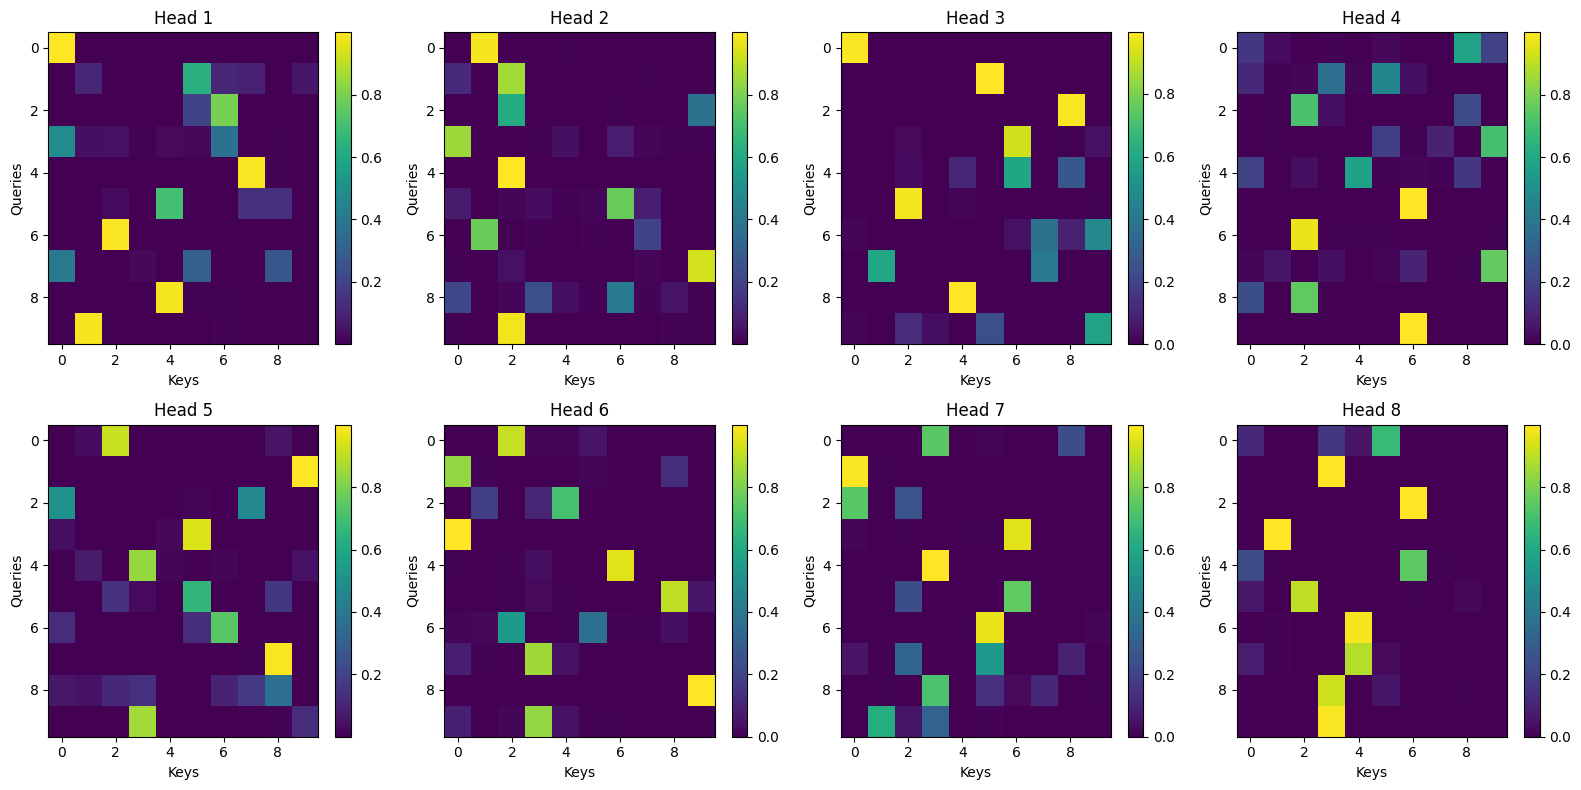

In [44]:
class MultiHeadAttention:
    def __init__(self, d_model, num_heads):
        """
        Multi-Head Attention
        Args:
            d_model: Dimension of the model
            num_heads: Number of attention heads
        """
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        # Initialize projection matrices
        self.W_q = np.random.randn(d_model, d_model) * 0.1
        self.W_k = np.random.randn(d_model, d_model) * 0.1
        self.W_v = np.random.randn(d_model, d_model) * 0.1
        self.W_o = np.random.randn(d_model, d_model) * 0.1

    def split_heads(self, x):
        """
        Split the last dimension into (num_heads, d_k)
        Args:
            x: Input tensor (batch_size, seq_len, d_model)
        Returns:
            Reshaped tensor (batch_size, num_heads, seq_len, d_k)
        """
        batch_size, seq_len, _ = x.shape
        x = x.reshape(batch_size, seq_len, self.num_heads, self.d_k)
        return x.transpose(0, 2, 1, 3)

    def combine_heads(self, x):
        """
        Combine heads back to original shape
        Args:
            x: Input tensor (batch_size, num_heads, seq_len, d_k)
        Returns:
            Combined tensor (batch_size, seq_len, d_model)
        """
        batch_size, _, seq_len, _ = x.shape
        x = x.transpose(0, 2, 1, 3)
        return x.reshape(batch_size, seq_len, self.d_model)

    def forward(self, Q, K, V, mask=None):
        """
        Forward pass of multi-head attention
        Args:
            Q: Queries (batch_size, seq_len_q, d_model)
            K: Keys (batch_size, seq_len_k, d_model)
            V: Values (batch_size, seq_len_v, d_model)
            mask: Optional mask
        Returns:
            output: Attention output
            attention_weights: Attention weights for all heads
        """
        batch_size = Q.shape[0]
        
        # Linear projections
        Q = np.matmul(Q, self.W_q)
        K = np.matmul(K, self.W_k)
        V = np.matmul(V, self.W_v)

        # Split into multiple heads
        Q = self.split_heads(Q)  # (batch, num_heads, seq_len_q, d_k)
        K = self.split_heads(K)  # (batch, num_heads, seq_len_k, d_k)
        V = self.split_heads(V)  # (batch, num_heads, seq_len_v, d_k)

        # Scaled dot-product attention
        scores = np.matmul(Q, K.transpose(0, 1, 3, 2)) / np.sqrt(self.d_k)
        if mask is not None:
            scores = scores + (mask * -1e9)
        attention_weights = softmax(scores, axis=-1)
        attention_output = np.matmul(attention_weights, V)
        
        # Combine heads
        output = self.combine_heads(attention_output)
        
        # Final linear projection
        output = np.matmul(output, self.W_o)
        return output, attention_weights

# Test Multi-Head Attention
np.random.seed(42)
d_model, num_heads = 512, 8
batch_size, seq_len = 2, 10

mha = MultiHeadAttention(d_model, num_heads)
Q = np.random.randn(batch_size, seq_len, d_model)
K = np.random.randn(batch_size, seq_len, d_model)
V = np.random.randn(batch_size, seq_len, d_model)

output, attention_weights = mha.forward(Q, K, V)

print(f"Input shape: {Q.shape}")
print(f"Output shape: {output.shape}")
print(f"Attention weights shape: {attention_weights.shape}")
print(f"Number of heads: {num_heads}")
print(f"d_k per head: {mha.d_k}")

# Visualize attention patterns for different heads
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i in range(num_heads):
    im = axes[i].imshow(attention_weights[0, i], cmap='viridis', aspect='auto')
    axes[i].set_title(f'Head {i+1}')
    axes[i].set_xlabel('Keys')
    axes[i].set_ylabel('Queries')
    plt.colorbar(im, ax=axes[i])

plt.tight_layout()
plt.savefig('multihead_attention.png', dpi=300, bbox_inches='tight')
plt.show()


 # Percobaan 3: Positional Encoding

Positional encoding shape: (100, 512)


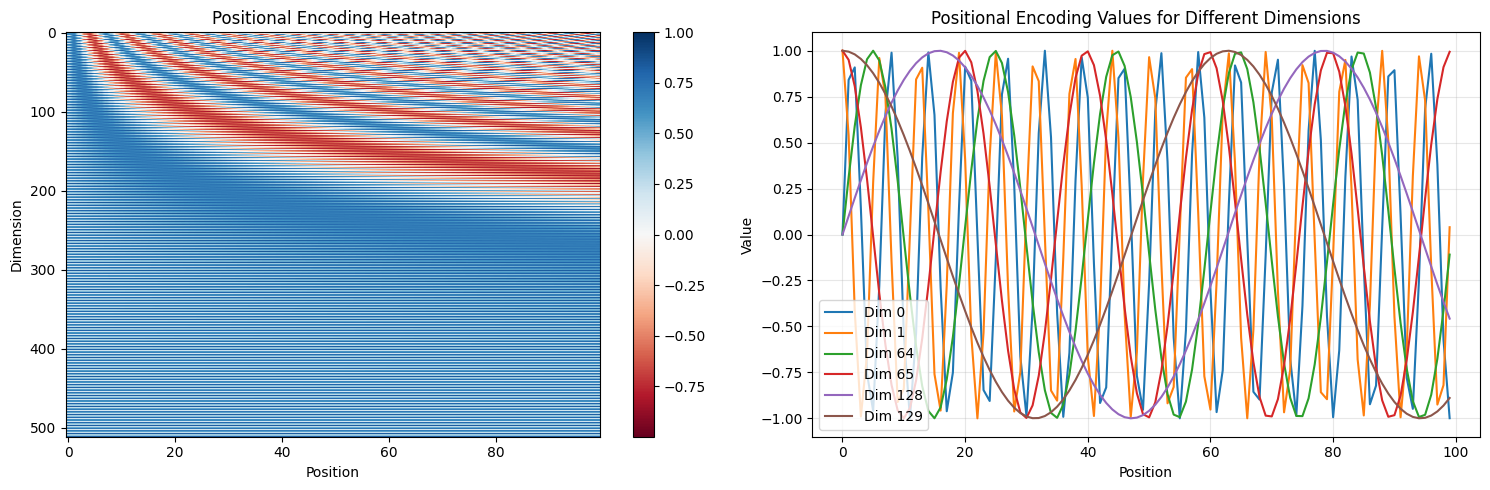


Relative Position Analysis:
Position 10 to 10 (offset=0)
Cosine similarity: 1.0000

Relative Position Analysis:
Position 10 to 11 (offset=1)
Cosine similarity: 0.9731

Relative Position Analysis:
Position 10 to 12 (offset=2)
Cosine similarity: 0.9052

Relative Position Analysis:
Position 10 to 13 (offset=3)
Cosine similarity: 0.8271

Relative Position Analysis:
Position 10 to 14 (offset=4)
Cosine similarity: 0.7683

Relative Position Analysis:
Position 10 to 15 (offset=5)
Cosine similarity: 0.7406

Relative Position Analysis:
Position 10 to 16 (offset=6)
Cosine similarity: 0.7353

Relative Position Analysis:
Position 10 to 17 (offset=7)
Cosine similarity: 0.7338

Relative Position Analysis:
Position 10 to 18 (offset=8)
Cosine similarity: 0.7225

Relative Position Analysis:
Position 10 to 19 (offset=9)
Cosine similarity: 0.7010

Relative Position Analysis:
Position 10 to 20 (offset=10)
Cosine similarity: 0.6789

Relative Position Analysis:
Position 10 to 21 (offset=11)
Cosine similarit

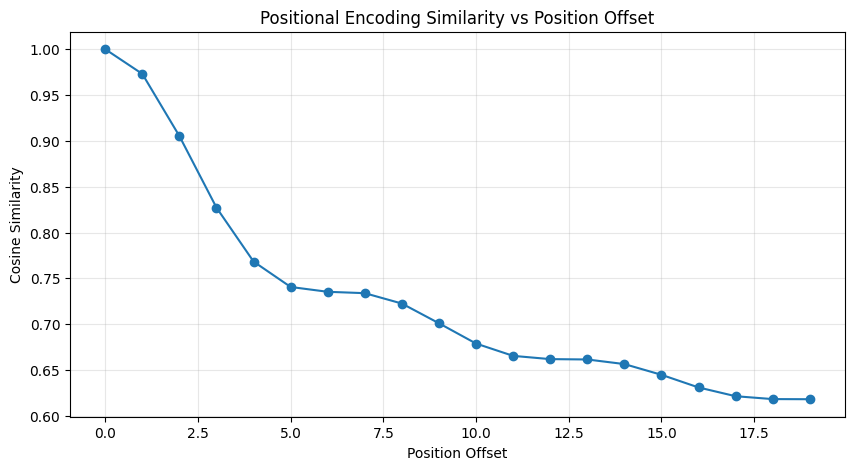

In [45]:
def positional_encoding(max_len, d_model):
    """
    Generate positional encoding
    Args:
        max_len: Maximum sequence length
        d_model: Dimension of the model
    Returns:
        pos_encoding: Positional encoding matrix (max_len, d_model)
    """
    pos_encoding = np.zeros((max_len, d_model))
    position = np.arange(0, max_len)[:, np.newaxis]
    div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
    
    # Apply sin to even indices
    pos_encoding[:, 0::2] = np.sin(position * div_term)
    # Apply cos to odd indices
    pos_encoding[:, 1::2] = np.cos(position * div_term)
    
    return pos_encoding

# Generate positional encoding
max_len, d_model = 100, 512
pos_enc = positional_encoding(max_len, d_model)
print(f"Positional encoding shape: {pos_enc.shape}")

# Visualize positional encoding
plt.figure(figsize=(15, 5))

# Plot full positional encoding
plt.subplot(1, 2, 1)
plt.imshow(pos_enc.T, cmap='RdBu', aspect='auto')
plt.colorbar()
plt.xlabel('Position')
plt.ylabel('Dimension')
plt.title('Positional Encoding Heatmap')

# Plot specific dimensions over positions
plt.subplot(1, 2, 2)
dims_to_plot = [0, 1, 64, 65, 128, 129]
for dim in dims_to_plot:
    plt.plot(pos_enc[:, dim], label=f'Dim {dim}')
plt.xlabel('Position')
plt.ylabel('Value')
plt.title('Positional Encoding Values for Different Dimensions')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('positional_encoding.png', dpi=300, bbox_inches='tight')
plt.show()

# Test relative position property
def demonstrate_relative_position(pos_enc, offset=5):
    """
    Demonstrate that relative positions can be represented
    as linear transformations
    """
    position_i = 10
    position_j = position_i + offset
    
    # Get encodings
    pe_i = pos_enc[position_i]
    pe_j = pos_enc[position_j]
    
    # Compute similarity
    similarity = np.dot(pe_i, pe_j) / (np.linalg.norm(pe_i) * np.linalg.norm(pe_j))
    
    print(f"\nRelative Position Analysis:")
    print(f"Position {position_i} to {position_j} (offset={offset})")
    print(f"Cosine similarity: {similarity:.4f}")
    return similarity

# Test different offsets
offsets = range(0, 20)
similarities = [demonstrate_relative_position(pos_enc, offset) for offset in offsets]

plt.figure(figsize=(10, 5))
plt.plot(offsets, similarities, 'o-')
plt.xlabel('Position Offset')
plt.ylabel('Cosine Similarity')
plt.title('Positional Encoding Similarity vs Position Offset')
plt.grid(True, alpha=0.3)
plt.savefig('pe_similarity.png', dpi=300, bbox_inches='tight')
plt.show()


# Percobaan 4: Transformer Encoder Layer

Input shape: (2, 10, 512)
Output shape: (2, 10, 512)
Attention weights shape: (2, 8, 10, 10)


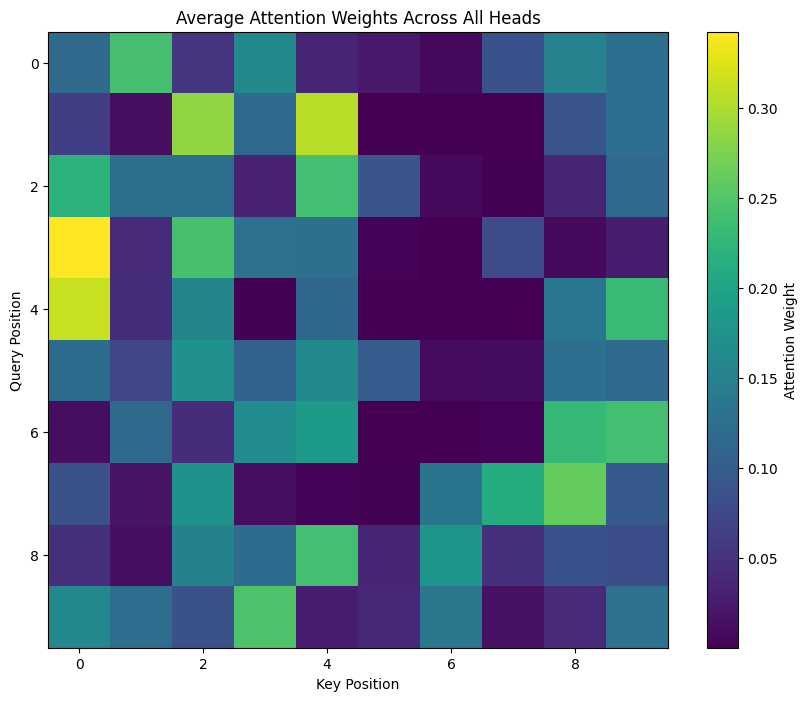

In [46]:
class LayerNormalization:
    def __init__(self, features, eps=1e-6):
        self.eps = eps
        self.gamma = np.ones(features)
        self.beta = np.zeros(features)
    
    def forward(self, x):
        mean = np.mean(x, axis=-1, keepdims=True)
        std = np.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta

class PositionwiseFeedForward:
    def __init__(self, d_model, d_ff):
        self.W1 = np.random.randn(d_model, d_ff) * 0.1
        self.b1 = np.zeros(d_ff)
        self.W2 = np.random.randn(d_ff, d_model) * 0.1
        self.b2 = np.zeros(d_model)
    
    def forward(self, x):
        # First layer with ReLU
        hidden = np.maximum(0, np.matmul(x, self.W1) + self.b1)
        # Second layer
        output = np.matmul(hidden, self.W2) + self.b2
        return output

class TransformerEncoderLayer:
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = PositionwiseFeedForward(d_model, d_ff)
        self.layernorm1 = LayerNormalization(d_model)
        self.layernorm2 = LayerNormalization(d_model)
        self.dropout = dropout
    
    def forward(self, x, mask=None):
        # Multi-head attention with residual connection and layer norm
        attn_output, attn_weights = self.mha.forward(x, x, x, mask)
        
        # Dropout (simulated by scaling)
        attn_output = attn_output * (1 - self.dropout)
        
        # Add & Norm
        x = self.layernorm1.forward(x + attn_output)
        
        # Feed-forward with residual connection and layer norm
        ffn_output = self.ffn.forward(x)
        
        # Dropout
        ffn_output = ffn_output * (1 - self.dropout)
        
        # Add & Norm
        output = self.layernorm2.forward(x + ffn_output)
        
        return output, attn_weights

# Test Transformer Encoder Layer
np.random.seed(42)
d_model, num_heads, d_ff = 512, 8, 2048
batch_size, seq_len = 2, 10

encoder_layer = TransformerEncoderLayer(d_model, num_heads, d_ff)

# Generate input with positional encoding
x = np.random.randn(batch_size, seq_len, d_model)
pos_enc = positional_encoding(seq_len, d_model)
x = x + pos_enc

# Forward pass
output, attn_weights = encoder_layer.forward(x)

print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")
print(f"Attention weights shape: {attn_weights.shape}")

# Visualize attention for first sample
plt.figure(figsize=(10, 8))
avg_attn = np.mean(attn_weights[0], axis=0)
plt.imshow(avg_attn, cmap='viridis', aspect='auto')
plt.colorbar(label='Attention Weight')
plt.xlabel('Key Position')
plt.ylabel('Query Position')
plt.title('Average Attention Weights Across All Heads')
plt.savefig('encoder_attention.png', dpi=300, bbox_inches='tight')
plt.show()


# Percobaan 5: Sequence-to-Sequence dengan Attention


In [47]:
import pandas as pd
from collections import Counter
import re

class Vocabulary:
    def __init__(self, freq_threshold=2):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold
    
    def build_vocabulary(self, sentence_list):
        frequencies = Counter()
        idx = 4
        for sentence in sentence_list:
            for word in sentence.split():
                frequencies[word] += 1
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1
    
    def numericalize(self, text):
        tokenized = text.split()
        return [self.stoi.get(token, self.stoi["<UNK>"]) for token in tokenized]
    
    def __len__(self):
        return len(self.itos)

def preprocess_text(text):
    """Simple text preprocessing"""
    text = text.lower()
    text = re.sub(r"([?.!,])", r" \1 ", text)
    text = re.sub(r'[" "]+', " ", text)
    text = text.strip()
    return text

# Load and prepare data
def load_translation_data(file_path, num_examples=10000):
    """
    Load translation data
    Expected format: English\tFrench
    """
    data = pd.read_csv(file_path, sep='\t', header=None,
                       names=['english', 'french'], nrows=num_examples)
    data['english'] = data['english'].apply(preprocess_text)
    data['french'] = data['french'].apply(preprocess_text)
    return data

# Simple Seq2Seq with Attention (using simplified encoder-decoder)
class SimpleSeq2SeqAttention:
    def __init__(self, src_vocab_size, tgt_vocab_size, embed_size, hidden_size, num_heads=4):
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        
        # Embeddings
        self.src_embedding = np.random.randn(src_vocab_size, embed_size) * 0.1
        self.tgt_embedding = np.random.randn(tgt_vocab_size, embed_size) * 0.1
        
        # Encoder (simplified as linear transformation)
        self.encoder_transform = np.random.randn(embed_size, hidden_size) * 0.1
        
        # Attention mechanism
        self.attention = MultiHeadAttention(hidden_size, num_heads)
        
        # Decoder
        self.decoder_transform = np.random.randn(hidden_size, hidden_size) * 0.1
        self.output_projection = np.random.randn(hidden_size, tgt_vocab_size) * 0.1
    
    def encode(self, src_seq):
        """
        Encode source sequence
        Args:
            src_seq: Source sequence indices (batch_size, src_len)
        Returns:
            Encoder outputs (batch_size, src_len, hidden_size)
        """
        # Get embeddings
        src_embed = self.src_embedding[src_seq]
        
        # Add positional encoding
        pos_enc = positional_encoding(src_seq.shape[1], self.embed_size)
        src_embed = src_embed + pos_enc
        
        # Transform to hidden size
        encoder_output = np.matmul(src_embed, self.encoder_transform)
        return encoder_output
    
    def decode_step(self, tgt_input, encoder_output, mask=None):
        """
        Single decoding step
        Args:
            tgt_input: Target input (batch_size, tgt_len, hidden_size)
            encoder_output: Encoder outputs (batch_size, src_len, hidden_size)
            mask: Optional attention mask
        Returns:
            decoder_output: Predictions (batch_size, tgt_len, tgt_vocab_size)
            attention_weights: Attention weights
        """
        # Cross-attention
        attended, attention_weights = self.attention.forward(
            tgt_input, encoder_output, encoder_output, mask
        )
        
        # Decoder transformation
        decoder_hidden = np.matmul(attended, self.decoder_transform)
        decoder_hidden = np.maximum(0, decoder_hidden)  # ReLU
        
        # Output projection
        decoder_output = np.matmul(decoder_hidden, self.output_projection)
        return decoder_output, attention_weights
    
    def predict(self, src_seq, max_len=20):
        """
        Generate translation
        Args:
            src_seq: Source sequence (batch_size, src_len)
            max_len: Maximum target length
        Returns:
            predictions: Generated sequence
        """
        # Encode
        encoder_output = self.encode(src_seq)
        batch_size = src_seq.shape[0]
        predictions = np.ones((batch_size, 1), dtype=int)  # Start with <SOS>
        
        for _ in range(max_len):
            # Get target embeddings
            tgt_embed = self.tgt_embedding[predictions]
            pos_enc = positional_encoding(predictions.shape[1], self.embed_size)
            tgt_embed = tgt_embed + pos_enc[:predictions.shape[1]]
            
            # Transform to hidden size
            tgt_hidden = np.matmul(tgt_embed, self.encoder_transform)
            
            # Decode
            output, _ = self.decode_step(tgt_hidden, encoder_output)
            
            # Get next token
            next_token = np.argmax(output[:, -1, :], axis=-1, keepdims=True)
            predictions = np.concatenate([predictions, next_token], axis=1)
            
            # Stop if all sequences generated <EOS>
            if np.all(next_token == 2):  # 2 is <EOS>
                break
        
        return predictions

# Example usage (with dummy data for demonstration)
print("Creating vocabularies and model...")

# Create dummy data
src_vocab_size, tgt_vocab_size = 5000, 5000
embed_size, hidden_size = 256, 512

model = SimpleSeq2SeqAttention(src_vocab_size, tgt_vocab_size, embed_size, hidden_size)

# Test with random input
batch_size, src_len = 2, 10
src_seq = np.random.randint(0, src_vocab_size, (batch_size, src_len))
print(f"Source sequence shape: {src_seq.shape}")

# Encode
encoder_output = model.encode(src_seq)
print(f"Encoder output shape: {encoder_output.shape}")

# Generate translation
predictions = model.predict(src_seq, max_len=15)
print(f"Predictions shape: {predictions.shape}")
print(f"Sample prediction: {predictions[0]}")


Creating vocabularies and model...
Source sequence shape: (2, 10)
Encoder output shape: (2, 10, 512)
Predictions shape: (2, 16)
Sample prediction: [   1 2889 2889 2889 4165 4165 4165 4165 4165 4165 2889 2889 2889 4165
 4165 4165]
Predictions shape: (2, 16)
Sample prediction: [   1 2889 2889 2889 4165 4165 4165 4165 4165 4165 2889 2889 2889 4165
 4165 4165]
